In [ ]:
import sys
#sys.path.append("/home/ubuntu/projects/ts-graph-inference/")

#from ts_graph_inference.data_utils import *
import seaborn as sns
import matplotlib.pyplot as plt


import msprime
#import allel
from scipy.spatial.distance import squareform
from sklearn.metrics import pairwise_distances
import numpy as np
import pandas as pd

In [ ]:
def get_population_time(time_rate:float=0.06, tmax:int = 130_000,
                        num_time_windows:int = 21
                       ) -> np.array :
    """Creates population time points; used as time points to change
    population size changes for simulation
    
    :return numpy.ndarray: time points of length num_time_windows
    """

    population_time = np.repeat([(np.exp(np.log(1 + time_rate * tmax) * i /
                              (num_time_windows - 1)) - 1) / time_rate for i in
                              range(num_time_windows)], 1, axis=0)
    population_time[0] = 1
    return population_time


def sample_population_size(n_min:int=10, n_max:int=100_000, num_time_windows=21) -> list[float]:

    """Creates random demography. Function taken from: 
    https://gitlab.inria.fr/ml_genetics/public/dlpopsize_paper
    
    :param int n_min: Lower-bound of demography.
    :param int n_max: Upper-bound of demography.
    :param int num_time_windows: Number of population sizes in demography.
    :return list: 
    """

    n_min_log10 = np.log10(n_min)
    n_max_log10 = np.log10(n_max)
    population_size = [10 ** np.random.uniform(low=n_min_log10, high=n_max_log10)]
    for j in range(num_time_windows - 1):
        population_size.append(10 ** n_min_log10 - 1)
        while population_size[-1] > 10 ** n_max_log10 or population_size[-1]  < 10 ** n_min_log10:
            population_size[-1] = population_size[-2] * 10 ** np.random.uniform(-1, 1)

    return population_size


def get_random_time_and_demography():
    from scipy.interpolate import interp1d
    upper_out_of_bound = lower_out_of_bound = True
    while upper_out_of_bound or lower_out_of_bound:
        steps = 18
        x = np.log(get_population_time(time_rate=0.1, num_time_windows=steps, tmax=10_000_000).tolist())
        y = np.log(sample_population_size(10_000, 10_000_000, steps))
        xnew = np.linspace(x[0], x[-1], num=10000, endpoint=True)
        f_cubic = interp1d(x, y, kind='cubic')
        ynew = f_cubic(xnew)
        upper_out_of_bound = np.sum(np.exp(ynew) > 10_000_000) > 0
        lower_out_of_bound = np.sum(np.exp(ynew) < 10_000) > 0
    x_sample = xnew[np.linspace(10, 9999, 60).astype(int)]
    y_sample = ynew[np.linspace(10, 9999, 60).astype(int)]
    demography = np.exp(y_sample)
    population_time = np.exp(x_sample)
    return population_time, demography

population_time, demography = get_random_time_and_demography()
#sns.lineplot(x=population_time, y=demography)
#plt.yscale('log')
#plt.xscale('log')
#plt.ylim(1000, 100_000_000)
#plt.xlim(10,10_000_000)

In [ ]:
def treeseq2df(ts, addedhue=None, w=100):
    gn = allel.HaplotypeArray(ts.genotype_matrix())
    r = allel.rogers_huff_r(gn)
    s = squareform(r ** 2)
    s = np.triu(s)
    n_genotypes = s.shape[0]
    
    m = pd.DataFrame(s).melt()
    m.columns = ["genotype1", "distance"]
    m["genotype2"] = np.tile(np.arange(n_genotypes), n_genotypes)
    
    positions = [s.position for s in ts.sites()]
    m["position"] = np.tile(positions, n_genotypes)
    
    distance = pairwise_distances(np.array(positions)[None].T)
    pairdistances = pd.DataFrame(distance).melt().value.tolist()
    m["pairdistances"] = pairdistances
    
    if addedhue: m["hue"] = addedhue
    sm = m[m["distance"] >= 0.01]
    
    
    sm['binned'] = pd.cut(x=sm['pairdistances'], bins=np.linspace(0, ts.sequence_length, w))
    df2 = sm[["distance", "binned","hue"]].groupby(sm['binned']).mean().reset_index()
    position = [bin.left for bin in df2.binned]
    df2["position"] = position
    
    
    return df2

In [ ]:
import msprime

def kingman_constant(Ne=10**4, L=10_000_000, r=5e-8, num_replicates=1000, sample_size=10):
    alpha = 2.0
    demography=msprime.Demography()
    demography.add_population(initial_size=(Ne))
    db = msprime.DemographyDebugger(demography=demography)
    tree_sequences = msprime.sim_ancestry(samples=sample_size,
                            recombination_rate=r,
                            sequence_length=L,
                            demography=demography,ploidy=1,random_seed=((alpha+1)**2), num_replicates=num_replicates)
    demography = db.population_size_trajectory(population_time).flatten()
    return list(tree_sequences), demography 

def beta_constant(alpha, Ne = 10**6, r=5e-8,  L=10**4, num_replicates=1000, sample_size=10):
    
    
    demography=msprime.Demography()
    demography.add_population(initial_size=(Ne))

    db = msprime.DemographyDebugger(demography=demography,model=msprime.BetaCoalescent(alpha=alpha))
    tree_sequences = msprime.sim_ancestry(samples=10,
                                          recombination_rate=r, sequence_length=L, demography=demography,
                                          ploidy=1,model=msprime.BetaCoalescent(alpha=alpha),
                                          num_replicates=num_replicates)
    demography = db.population_size_trajectory(population_time).flatten()
    
    return list(tree_sequences), demography 



In [ ]:
#kingman_trees, _ = kingman_constant(Ne=10**4, L=10**4,  r=5e-8)

#beta_trees_1, _ = beta_constant(alpha=1.5, Ne=10**6, L=10**6,  r=5e-8)

#beta_trees_2, _ = beta_constant(alpha=1.1, Ne=10**6, L=100_000_000,  r=5e-8)

In [ ]:
from tqdm import tqdm
import allel
import warnings
warnings.filterwarnings("ignore")

In [ ]:
L = 0.5 * 10**6
kingman_trees, _ = kingman_constant(Ne=10**4, L=L,  r=1e-8, sample_size=10)
dfs = []
nmuts = []
tss = []
for i, ts in enumerate(tqdm(kingman_trees[:100])):
    ts = msprime.mutate(ts, rate=1e-7) #
    nmuts.append(ts.num_mutations)
    tss.append(ts)
    
w = L / np.mean(nmuts)
w = int(w / 2)
print(w)

for ts in tqdm(tss):
    df = treeseq2df(ts, str(i), w)
    dfs.append(df)
kingman_dfs = pd.concat(dfs)
kingman_dfs.reset_index(inplace=True)
kingman_dfs["binned"] = None


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 453.55it/s]


88


100%|█████████████████████████████████████████| 100/100 [03:20<00:00,  2.01s/it]


In [ ]:
kingman_dfs.to_csv("k_r1e-8_m1e-7_w88_l5e5.csv")

In [ ]:
kingman_dfs.to_csv("k_r1e-8_m3e-7_w29_l1e5.csv")

<Axes: xlabel='position', ylabel='distance'>

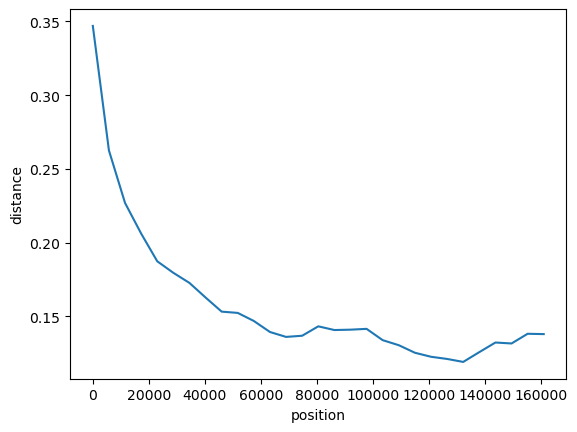

In [ ]:
dfs = kingman_dfs[0:29]
sns.lineplot(data=dfs, x="position", y="distance")

In [ ]:
L = 0.5*10**6
beta_trees_15, _ = beta_constant(alpha=1.5, Ne=10**6, L=L,  r=1e-8) 
dfs = []
nmuts = []
tss = []
for i, ts in enumerate(tqdm(beta_trees_15[:100])):
    ts = msprime.mutate(ts, rate=1e-7) #
    nmuts.append(ts.num_mutations)
    tss.append(ts)
    
w = L / np.mean(nmuts)
w = int(w / 2)
print(w)

for ts in tqdm(tss):
    df = treeseq2df(ts, str(i), w)
    dfs.append(df)
    
beta_dfs = pd.concat(dfs)
beta_dfs.reset_index(inplace=True)
beta_dfs["binned"] = None

100%|███████████████████████████████████████| 100/100 [00:00<00:00, 1490.01it/s]


517


100%|█████████████████████████████████████████| 100/100 [00:08<00:00, 12.00it/s]


In [ ]:
beta_dfs.to_csv("b15_r1e-8_m1e-7_w507_l5e5.csv")

<Axes: xlabel='position', ylabel='distance'>

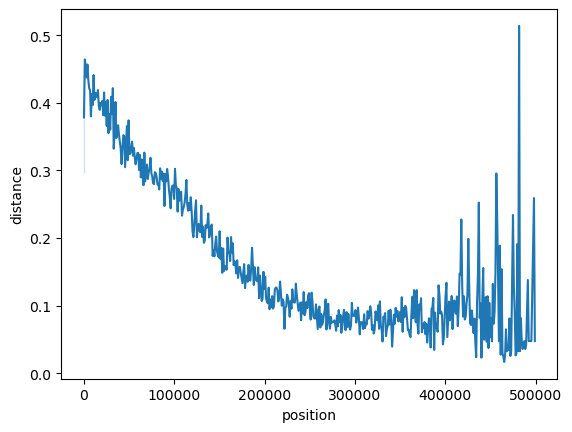

In [ ]:
dfs = beta_dfs[w*0:w*1]
sns.lineplot(data=dfs, x="position", y="distance")

In [ ]:
L = 500_000
beta_trees_3, _ = beta_constant(alpha=1.3, Ne=10**6, L=L,  r=1e-8)
dfs = []
nmuts = []
tss = []
for i, ts in enumerate(tqdm(beta_trees_3[:100])):
    ts = msprime.mutate(ts, rate=1e-7) #
    nmuts.append(ts.num_mutations)
    tss.append(ts)
    
w = L / np.mean(nmuts)
w = int(w / 2)
print(w)

for ts in tqdm(tss):
    df = treeseq2df(ts, str(i), w)
    dfs.append(df)
beta_dfs = pd.concat(dfs)
beta_dfs.reset_index(inplace=True)
beta_dfs["binned"] = None

100%|███████████████████████████████████████| 100/100 [00:00<00:00, 2192.65it/s]


3486


100%|█████████████████████████████████████████| 100/100 [00:09<00:00, 10.54it/s]


In [ ]:
beta_dfs.to_csv("b13_r1e-8_m3e-7_w3486_l5e5.csv")

In [ ]:
treeseq2df??

Signature: treeseq2df(ts, addedhue=None, w=100)
Docstring: <no docstring>
Source:   
def treeseq2df(ts, addedhue=None, w=100):
    gn = allel.HaplotypeArray(ts.genotype_matrix())
    r = allel.rogers_huff_r(gn)
    s = squareform(r ** 2)
    s = np.triu(s)
    n_genotypes = s.shape[0]
    
    m = pd.DataFrame(s).melt()
    m.columns = ["genotype1", "distance"]
    m["genotype2"] = np.tile(np.arange(n_genotypes), n_genotypes)
    
    positions = [s.position for s in ts.sites()]
    m["position"] = np.tile(positions, n_genotypes)
    
    distance = pairwise_distances(np.array(positions)[None].T)
    pairdistances = pd.DataFrame(distance).melt().value.tolist()
    m["pairdistances"] = pairdistances
    
    if addedhue: m["hue"] = addedhue
    sm = m[m["distance"] >= 0.01]
    
    
    sm['binned'] = pd.cut(x=sm['pairdistances'], bins=np.linspace(0, ts.sequence_length, w))
    df2 = sm[["distance", "binned","hue"]].groupby(sm['binned']).mean().reset_index()
    position = [bin.left fo

In [ ]:
kingman_dfs = pd.read_csv("k_r1e-8_m1e-7_w88_l5e5.csv")
beta_dfs = pd.read_csv("b15_r1e-8_m1e-7_w507_l5e5.csv")
beta_dfs_2 = pd.read_csv("b13_r1e-8_m3e-7_w3486_l5e5.csv")

In [ ]:
kingman_dfs = pd.read_csv("k_r1e-8_m3e-7_w29_l1e5.csv")
beta_dfs = pd.read_csv("b15_r1e-8_m3e-7_w169_l5e5.csv")
beta_dfs_2 = pd.read_csv("b13_r1e-8_m3e-7_w1065_l1e6.csv")

In [ ]:
[1e5/29, 5e5/169, 1e6/1065]

[3448.2758620689656, 2958.579881656805, 938.9671361502348]

In [ ]:
[5e5/88, 5e5/507, 5e5/3486]

[5681.818181818182, 986.1932938856016, 143.4308663224326]

In [ ]:
10**6

1000000

In [ ]:
⁴

In [ ]:
kingman_dfs = pd.read_csv("k_r1e-8_m1e-7_w88_l5e5.csv")
beta_dfs = pd.read_csv("b15_r1e-8_m1e-7_w507_l5e5.csv")
beta_dfs_2 = pd.read_csv("b13_r1e-8_m3e-7_w3486_l5e5.csv")

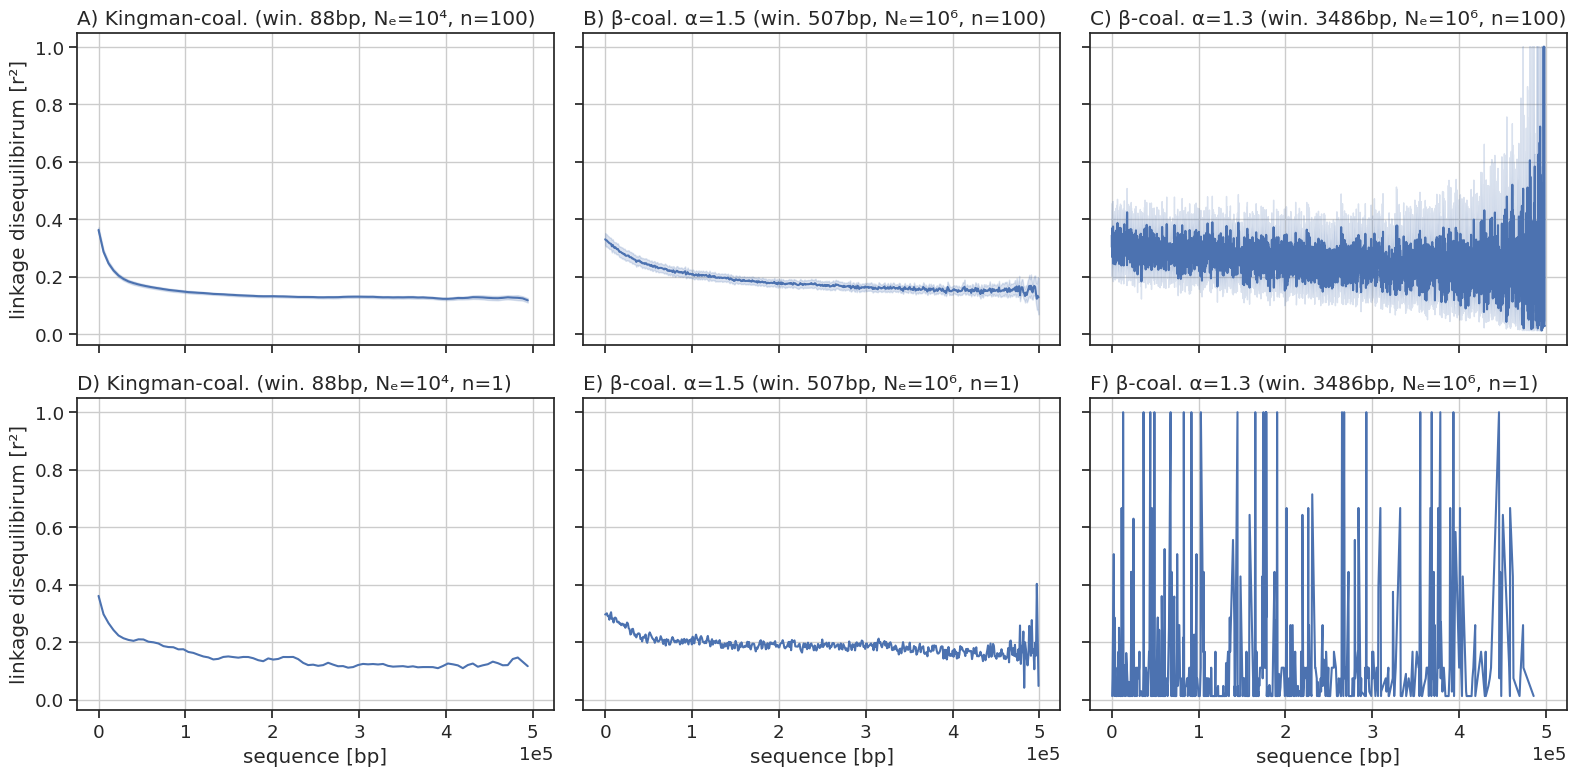

In [ ]:
sns.set(font_scale=1.2)
sns.set_style("ticks")

fig, ax = plt.subplots(2, 3, figsize=(16,8), sharex=True, sharey=True)
dfs = kingman_dfs
sns.lineplot(data=dfs, x="position", y="distance", ax=ax[0][0])
ax[0][0].set_xlabel("sequence [bp]")
ax[0][0].set_ylabel("linkage disequilibirum [r²]")
ax[0][0].set_title("A) Kingman-coal. (win. 88bp, Nₑ=10⁴, n=100)", loc="left")
ax[0][0].grid(True)
dfs = beta_dfs
sns.lineplot(data=dfs, x="position", y="distance", ax=ax[0][1])
ax[0][1].set_xlabel("sequence [bp]")
ax[0][1].set_ylabel("linkage disequilibirum [r²]")
ax[0][1].set_title("B) β-coal. α=1.5 (win. 507bp, Nₑ=10⁶, n=100)", loc="left")
ax[0][1].grid(True)
dfs = beta_dfs_2
sns.lineplot(data=dfs, x="position", y="distance", ax=ax[0][2])
ax[0][2].set_xlabel("sequence [bp]")
ax[0][2].set_ylabel("linkage disequilibirum [r²]")
ax[0][2].set_title("C) β-coal. α=1.3 (win. 3486bp, Nₑ=10⁶, n=100)", loc="left")
ax[0][2].grid(True)
plt.tight_layout()
ax[0][0].ticklabel_format(style='sci', axis='x', scilimits=(0,0))


dfs = kingman_dfs
i = 1
j = 1
span = dfs["index"].iloc[-1]
dfs = dfs[span*j:span*(j+1)]
sns.lineplot(data=dfs, x="position", y="distance", ax=ax[i][0])
ax[i][0].set_xlabel("sequence [bp]")
ax[i][0].set_ylabel("linkage disequilibirum [r²]")
ax[i][0].set_title("D) Kingman-coal. (win. 88bp, Nₑ=10⁴, n=1)", loc="left")
ax[i][0].grid(True)
dfs = beta_dfs
span = dfs["index"].iloc[-1]
dfs = dfs[span*j:span*(j+1)]
sns.lineplot(data=dfs, x="position", y="distance", ax=ax[i][1])
ax[i][1].set_xlabel("sequence [bp]")
ax[i][1].set_ylabel("linkage disequilibirum [r²]")
ax[i][1].set_title("E) β-coal. α=1.5 (win. 507bp, Nₑ=10⁶, n=1)", loc="left")
ax[i][1].grid(True)
dfs = beta_dfs_2
span = dfs["index"].iloc[-1]
dfs = dfs[span*j:span*(j+1)]
sns.lineplot(data=dfs, x="position", y="distance", ax=ax[i][2])
ax[i][2].set_xlabel("sequence [bp]")
ax[i][2].set_ylabel("linkage disequilibirum [r²]")
ax[i][2].set_title("F) β-coal. α=1.3 (win. 3486bp, Nₑ=10⁶, n=1)", loc="left")
ax[i][2].grid(True)

plt.tight_layout()
ax[0][j].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
fig.savefig("./Figure_2_new_new_same_axis.pdf", dpi=600)

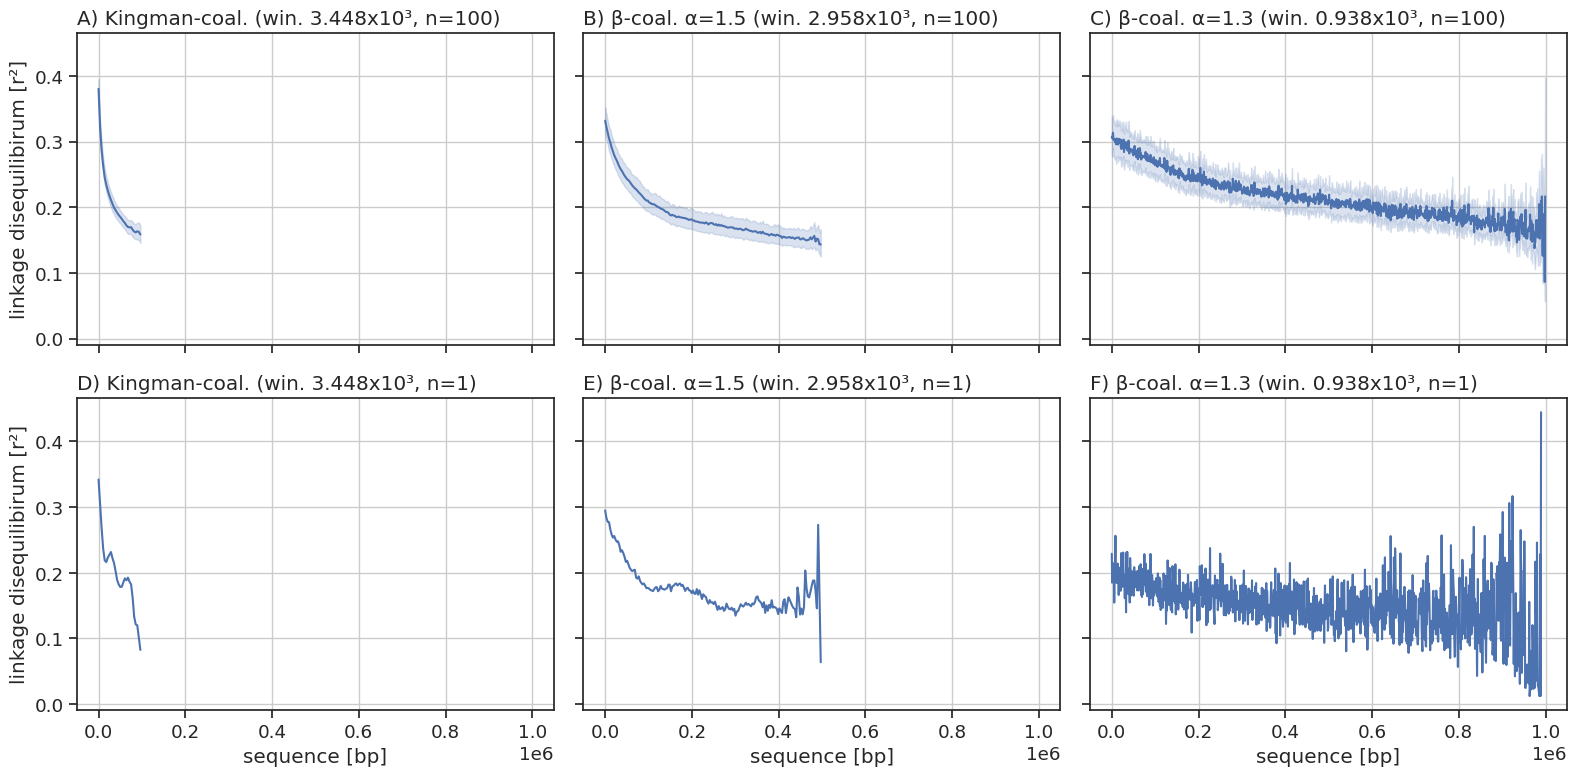

In [ ]:
sns.set(font_scale=1.2)
sns.set_style("ticks")

fig, ax = plt.subplots(2, 3, figsize=(16,8), sharex=True, sharey=True)
dfs = kingman_dfs
sns.lineplot(data=dfs, x="position", y="distance", ax=ax[0][0])
ax[0][0].set_xlabel("sequence [bp]")
ax[0][0].set_ylabel("linkage disequilibirum [r²]")
ax[0][0].set_title("A) Kingman-coal. (win. 3.448x10³, n=100)", loc="left")
ax[0][0].grid(True)
dfs = beta_dfs
sns.lineplot(data=dfs, x="position", y="distance", ax=ax[0][1])
ax[0][1].set_xlabel("sequence [bp]")
ax[0][1].set_ylabel("linkage disequilibirum [r²]")
ax[0][1].set_title("B) β-coal. α=1.5 (win. 2.958x10³, n=100)", loc="left")
ax[0][1].grid(True)
dfs = beta_dfs_2
sns.lineplot(data=dfs, x="position", y="distance", ax=ax[0][2])
ax[0][2].set_xlabel("sequence [bp]")
ax[0][2].set_ylabel("linkage disequilibirum [r²]")
ax[0][2].set_title("C) β-coal. α=1.3 (win. 0.938x10³, n=100)", loc="left")
ax[0][2].grid(True)
plt.tight_layout()
ax[0][0].ticklabel_format(style='sci', axis='x', scilimits=(0,0))


dfs = kingman_dfs
i = 1
j = 1
span = dfs["index"].iloc[-1]
dfs = dfs[span*j:span*(j+1)]
sns.lineplot(data=dfs, x="position", y="distance", ax=ax[i][0])
ax[i][0].set_xlabel("sequence [bp]")
ax[i][0].set_ylabel("linkage disequilibirum [r²]")
ax[i][0].set_title("D) Kingman-coal. (win. 3.448x10³, n=1)", loc="left")
ax[i][0].grid(True)
dfs = beta_dfs
span = dfs["index"].iloc[-1]
dfs = dfs[span*j:span*(j+1)]
sns.lineplot(data=dfs, x="position", y="distance", ax=ax[i][1])
ax[i][1].set_xlabel("sequence [bp]")
ax[i][1].set_ylabel("linkage disequilibirum [r²]")
ax[i][1].set_title("E) β-coal. α=1.5 (win. 2.958x10³, n=1)", loc="left")
ax[i][1].grid(True)
dfs = beta_dfs_2
span = dfs["index"].iloc[-1]
dfs = dfs[span*j:span*(j+1)]
sns.lineplot(data=dfs, x="position", y="distance", ax=ax[i][2])
ax[i][2].set_xlabel("sequence [bp]")
ax[i][2].set_ylabel("linkage disequilibirum [r²]")
ax[i][2].set_title("F) β-coal. α=1.3 (win. 0.938x10³, n=1)", loc="left")
ax[i][2].grid(True)

plt.tight_layout()
ax[0][j].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
fig.savefig("./Figure_2_new_same_axis.pdf", dpi=600)

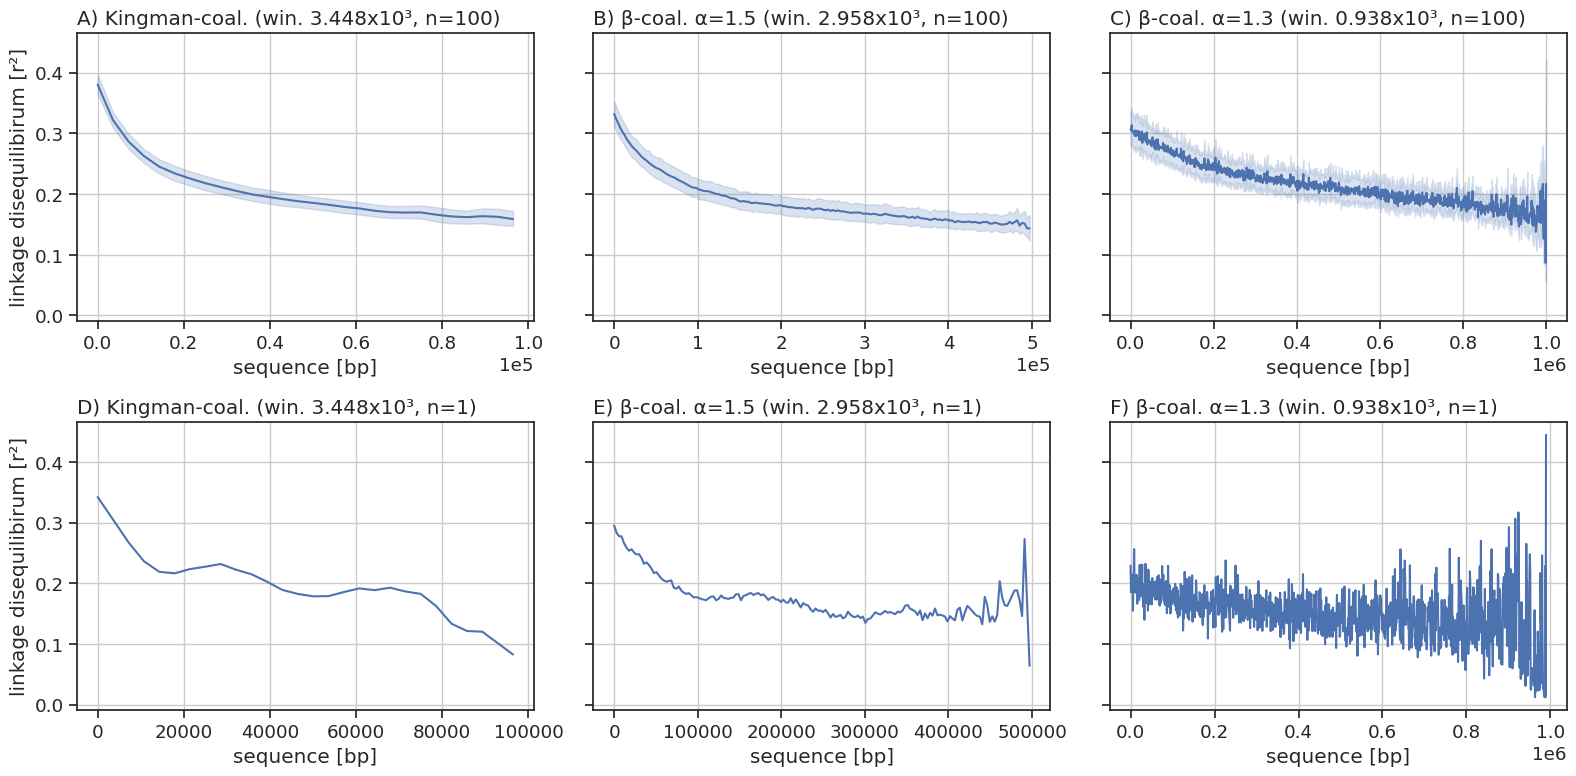

In [ ]:
sns.set(font_scale=1.2)
sns.set_style("ticks")

fig, ax = plt.subplots(2, 3, figsize=(16,8), sharex=False, sharey=True)
dfs = kingman_dfs
sns.lineplot(data=dfs, x="position", y="distance", ax=ax[0][0])
ax[0][0].set_xlabel("sequence [bp]")
ax[0][0].set_ylabel("linkage disequilibirum [r²]")
ax[0][0].set_title("A) Kingman-coal. (win. 3.448x10³, n=100)", loc="left")
ax[0][0].grid(True)
dfs = beta_dfs
sns.lineplot(data=dfs, x="position", y="distance", ax=ax[0][1])
ax[0][1].set_xlabel("sequence [bp]")
ax[0][1].set_ylabel("linkage disequilibirum [r²]")
ax[0][1].set_title("B) β-coal. α=1.5 (win. 2.958x10³, n=100)", loc="left")
ax[0][1].grid(True)
dfs = beta_dfs_2
sns.lineplot(data=dfs, x="position", y="distance", ax=ax[0][2])
ax[0][2].set_xlabel("sequence [bp]")
ax[0][2].set_ylabel("linkage disequilibirum [r²]")
ax[0][2].set_title("C) β-coal. α=1.3 (win. 0.938x10³, n=100)", loc="left")
ax[0][2].grid(True)
plt.tight_layout()
ax[0][0].ticklabel_format(style='sci', axis='x', scilimits=(0,0))


dfs = kingman_dfs
i = 1
j = 1
span = dfs["index"].iloc[-1]
dfs = dfs[span*j:span*(j+1)]
sns.lineplot(data=dfs, x="position", y="distance", ax=ax[i][0])
ax[i][0].set_xlabel("sequence [bp]")
ax[i][0].set_ylabel("linkage disequilibirum [r²]")
ax[i][0].set_title("D) Kingman-coal. (win. 3.448x10³, n=1)", loc="left")
ax[i][0].grid(True)
dfs = beta_dfs
span = dfs["index"].iloc[-1]
dfs = dfs[span*j:span*(j+1)]
sns.lineplot(data=dfs, x="position", y="distance", ax=ax[i][1])
ax[i][1].set_xlabel("sequence [bp]")
ax[i][1].set_ylabel("linkage disequilibirum [r²]")
ax[i][1].set_title("E) β-coal. α=1.5 (win. 2.958x10³, n=1)", loc="left")
ax[i][1].grid(True)
dfs = beta_dfs_2
span = dfs["index"].iloc[-1]
dfs = dfs[span*j:span*(j+1)]
sns.lineplot(data=dfs, x="position", y="distance", ax=ax[i][2])
ax[i][2].set_xlabel("sequence [bp]")
ax[i][2].set_ylabel("linkage disequilibirum [r²]")
ax[i][2].set_title("F) β-coal. α=1.3 (win. 0.938x10³, n=1)", loc="left")
ax[i][2].grid(True)

plt.tight_layout()
ax[0][j].ticklabel_format(style='sci', axis='x', scilimits=(0,0))

fig.savefig("./Figure_2_new.pdf", dpi=600)